In [1]:
import os
from kid_readout.measurement import core, legacy, multiple, single
from kid_readout.measurement.io import nc, npy, readoutnc
from kid_readout.analysis.resonator import plot_resonator

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
nc_filename = '/data/readout/2015-05-11_150346_compressor_noise_60_s.nc'
rnc = readoutnc.ReadoutNetCDF(nc_filename)
on_index = 0
off_index = 1

The last word on indexing seems to be that the TimestreamGroup of a SweepGroup has data in monotonic frequency order, while a bare TimestreamGroup has data in roach frequency order. The arrays sg.index and tg.sweep_index show the original order. The data blocks are processed in this order in sweeps.do_prepared_sweep, but the SweepData class sorts the blocks by frequency.

Note that sweep.fftbin is actually the fpga fft index + 1, not the roach fftbin.

In [3]:
sa = legacy.sweeparray_from_rnc(rnc, on_index)

In [4]:
s0 = sa.sweep(0)

In [5]:
rs0 = single.ResonatorSweep(s0.streams)

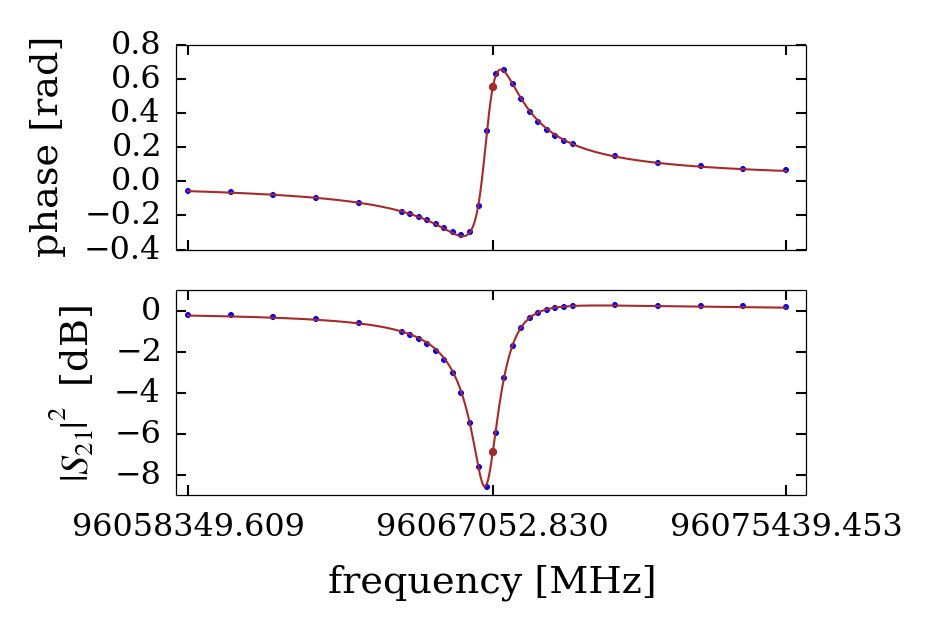

In [6]:
plot_resonator.amplitude_and_phase(rs0.resonator, normalize_s21=True);

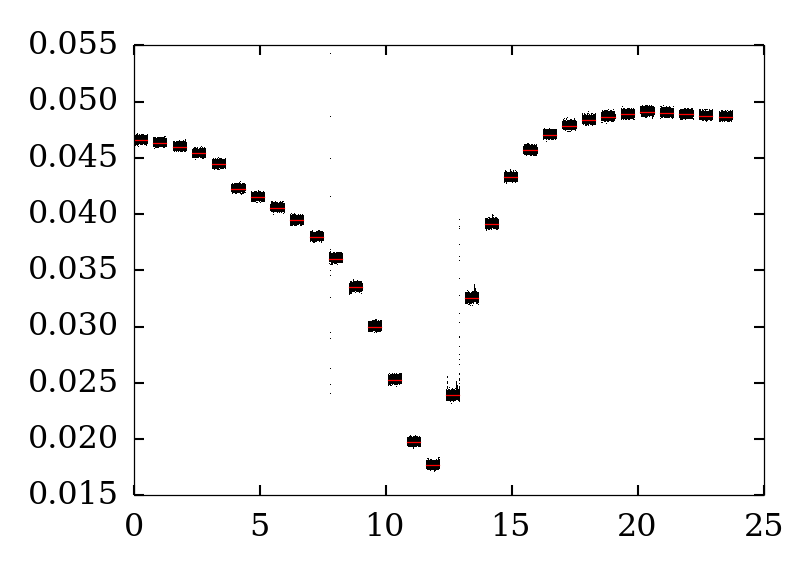

In [7]:
t0 = rs0.streams[0].epoch.min()
for s in rs0.streams:
    plt.plot(s.epoch - t0, np.abs(s.s21), ',k')
    plt.plot((s.epoch[0] - t0, s.epoch[-1] - t0), 2 * [np.abs(s.s21_mean)], '-r')

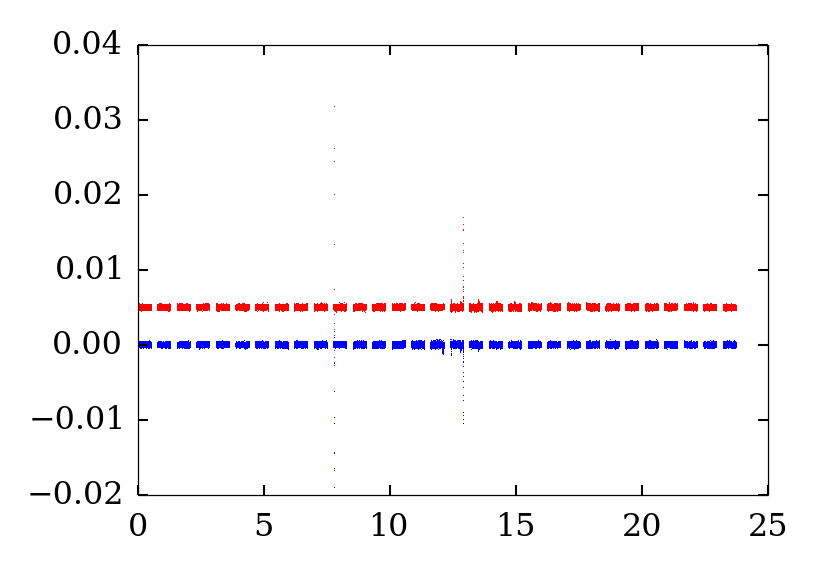

In [8]:
t0 = rs0.streams[0].epoch.min()
for s in rs0.streams:
    plt.plot(s.epoch - t0, (s.s21 - s.s21_mean).real, ',b')
    plt.plot(s.epoch - t0, 0.005 + (s.s21 - s.s21_mean).imag, ',r')    

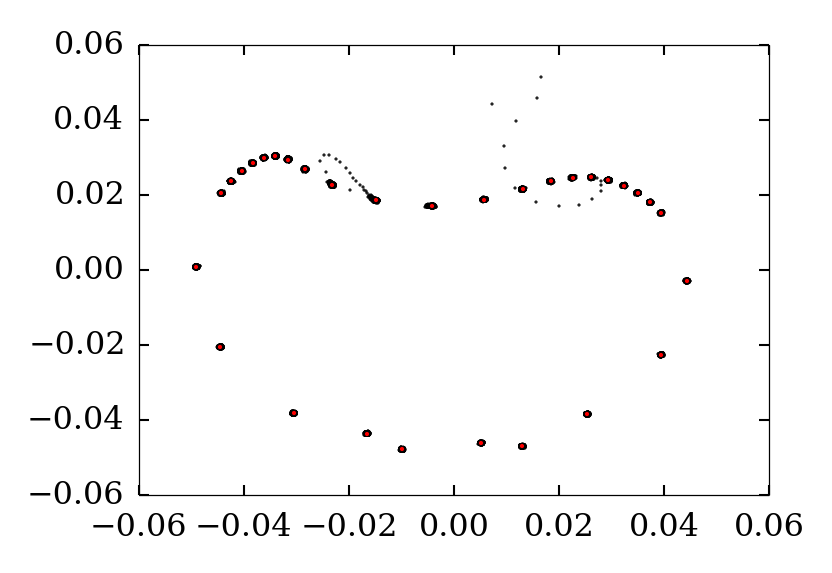

In [9]:
for s in rs0.streams:
    plt.plot(s.s21.real, s.s21.imag, '.k', ms=0.5)
    plt.plot(s.s21_mean.real, s.s21_mean.imag, '.r', ms=1)

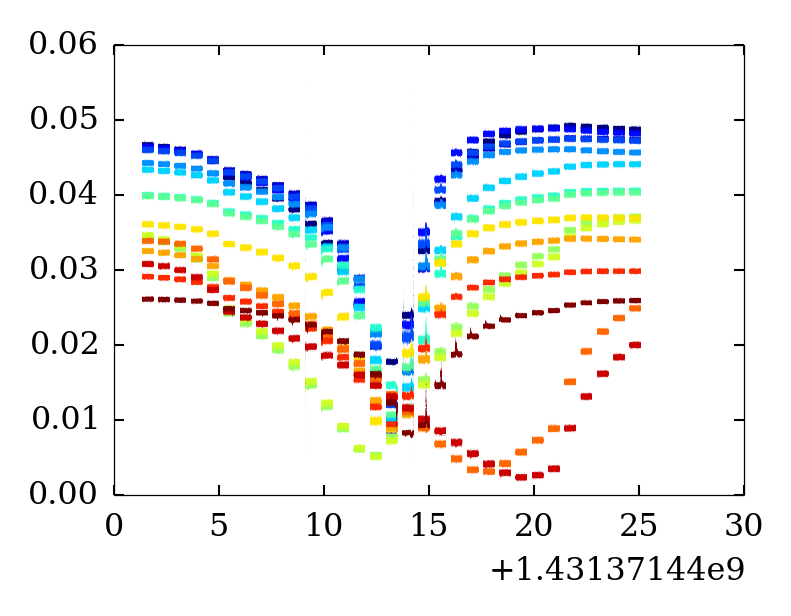

In [10]:
a = np.arange(sa.num_channels)
import matplotlib
mappable = plt.cm.ScalarMappable(matplotlib.colors.Normalize(), cmap=plt.cm.jet)
colors = mappable.to_rgba(a)
for stream_array in sa.stream_arrays:
    for n in a:
        s = stream_array.stream(n)
        plt.plot(s.epoch, np.abs(s.s21), ',', color=colors[n], alpha=0.1)

# SweepGroup

In [11]:
sg = rnc.sweeps[on_index]

Arrays `frequency` and `s21` are arranged in increasing frequency order, but `index` is not monotonic: it counts up from 0 by 1 until the corresponding frequency exceeds 128, then counts down from the last index.

In [12]:
sg.index.shape

(496,)

In [13]:
sg.frequency.shape

(496,)

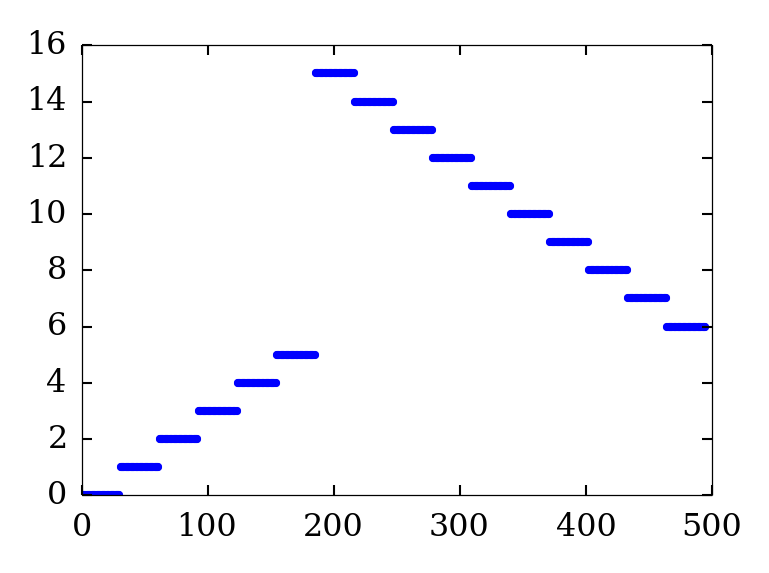

In [14]:
plt.plot(sg.index, '.')

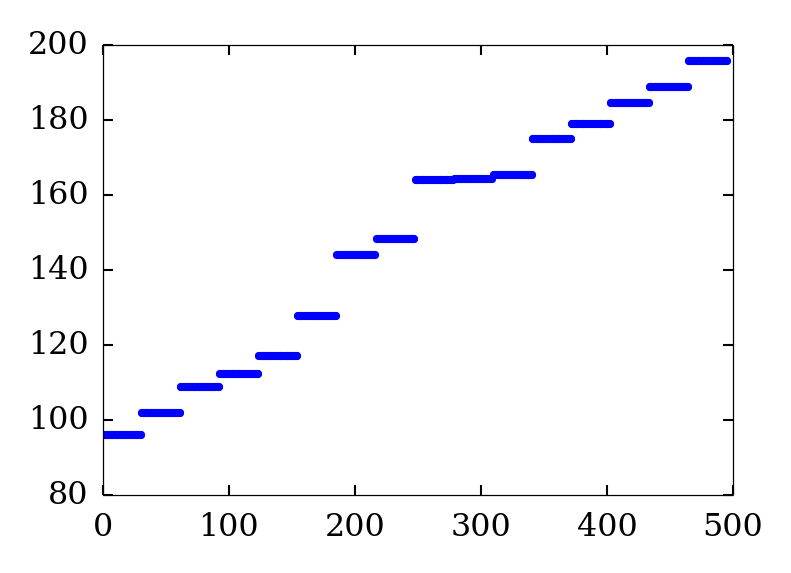

In [15]:
plt.plot(sg.frequency, '.')

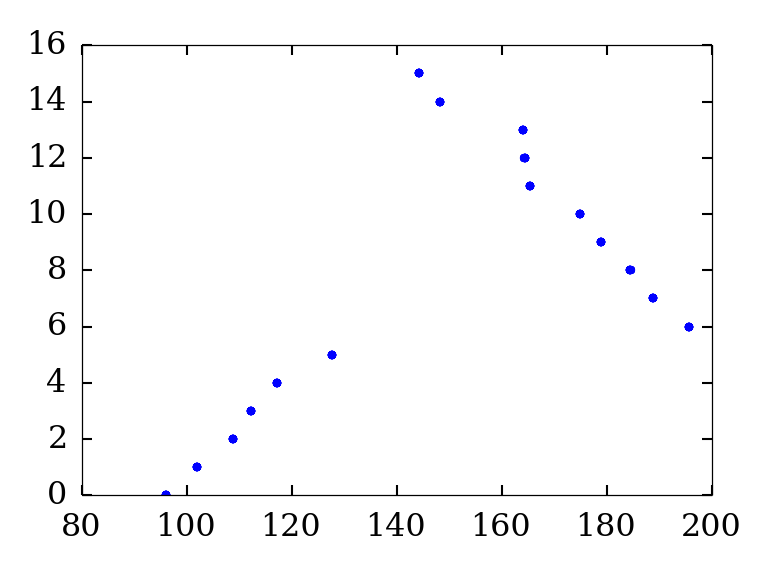

In [16]:
plt.plot(sg.frequency, sg.index, '.')

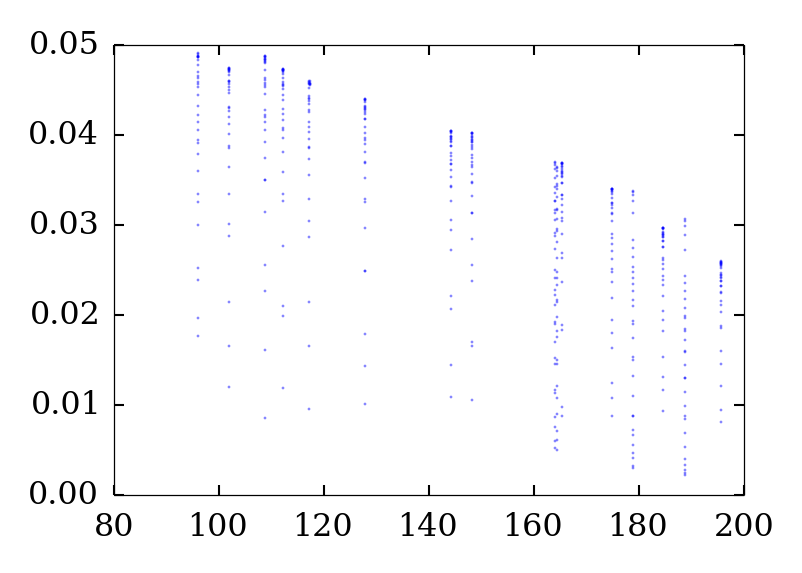

In [17]:
plt.plot(sg.frequency, np.abs(sg.s21), '.', ms=0.2)

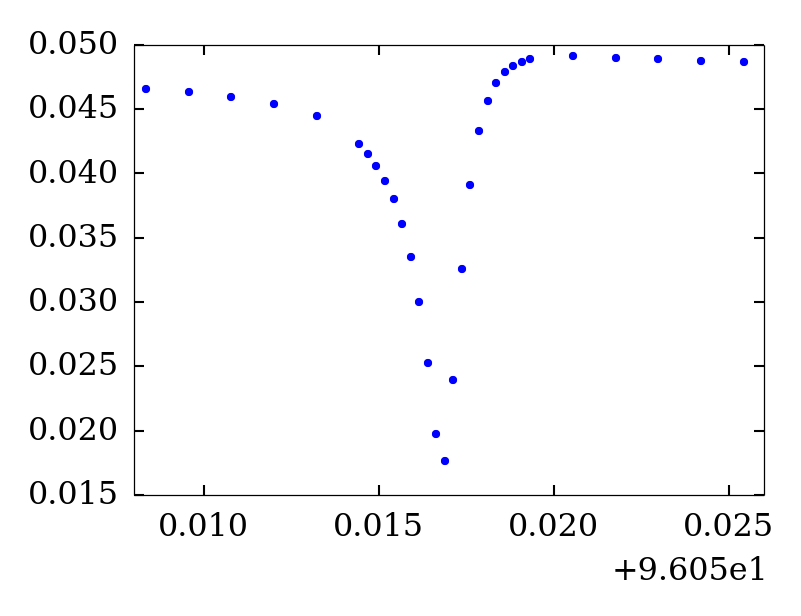

In [18]:
plt.plot(sg.frequency[sg.index==0], np.abs(sg.s21[sg.index==0]), '.')

In [19]:
sg.s21.shape

(496,)

In [20]:
n_channels = np.unique(sg.index).size
n_channels

16

In [21]:
frequencies_per_index = int(sg.frequency.size / n_channels)
frequencies_per_index

31

In [22]:
n_channels * frequencies_per_index

496

In [23]:
sg.frequency[::frequencies_per_index]

array([  96.05834961,  101.95605469,  108.85839844,  112.25634766,
        117.26611328,  127.78051758,  144.18383789,  148.24121094,
        164.07910156,  164.37036133,  165.40405273,  174.95166016,
        178.93701172,  184.55004883,  188.85839844,  195.70825195])

# TimestreamGroup of SweepGroup

In [24]:
tg = sg.timestream_group

Some of the SweepGroup arrays are identical to the TimestreamGroup arrays.

In [25]:
np.all(sg.index == tg.sweep_index)

True

In [26]:
np.all(sg.frequency == tg.measurement_freq)

True

The SweepGroup doesn't have all the epoch data:

In [27]:
tg.epoch.shape

(496,)

In [28]:
tg.data_len_seconds.shape

(496,)

The data array is `n_streams` by `tg.num_data_samples`:

In [29]:
tg.data.shape

(496, 8192)

In [30]:
tg.num_data_samples

8192

In [31]:
data_mean = np.mean(tg.data, axis=1)

In [32]:
data_mean.dtype

dtype('complex128')

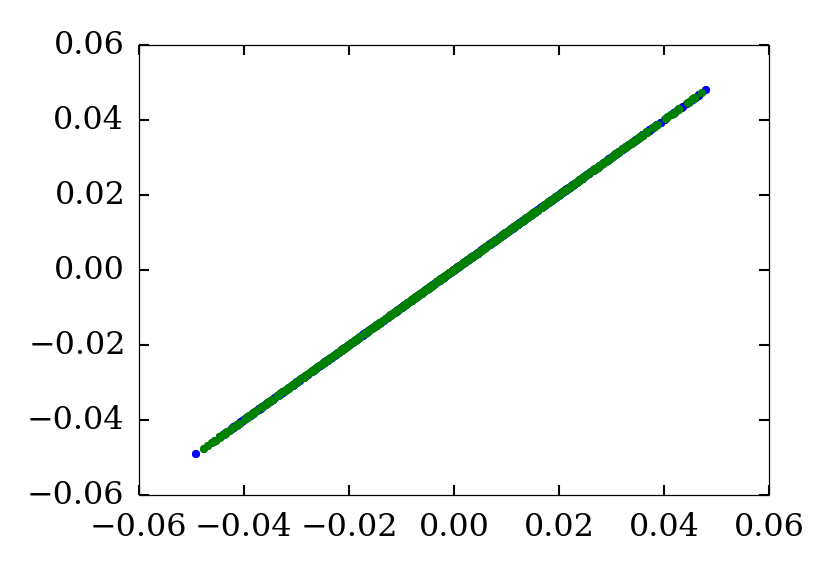

In [33]:
plt.plot(sg.s21.real, data_mean.real, '.')
plt.plot(sg.s21.imag, data_mean.imag, '.')

In [34]:
tg.epoch[::frequencies_per_index] - tg.epoch.min()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [35]:
tg.epoch[:frequencies_per_index] - tg.epoch.min()

array([  0.        ,   0.77221608,   1.55145311,   2.32473993,
         3.10197496,   3.88138914,   4.65785098,   5.43400812,
         6.20880294,   6.98333216,   7.75915909,   8.53130603,
         9.30900908,  10.07941198,  10.84969902,  11.61490512,
        12.38891006,  13.15271115,  13.93458104,  14.70062304,
        15.46977615,  16.241781  ,  17.01772404,  17.78878713,
        18.56249499,  19.33847094,  20.11436105,  20.88913703,
        21.66112208,  22.44213009,  23.21360803])

This indexing picks out the data that is simultaneously sampled:

In [36]:
for n in range(frequencies_per_index):
    print(np.all(np.diff(tg.epoch[n::frequencies_per_index]) == 0))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


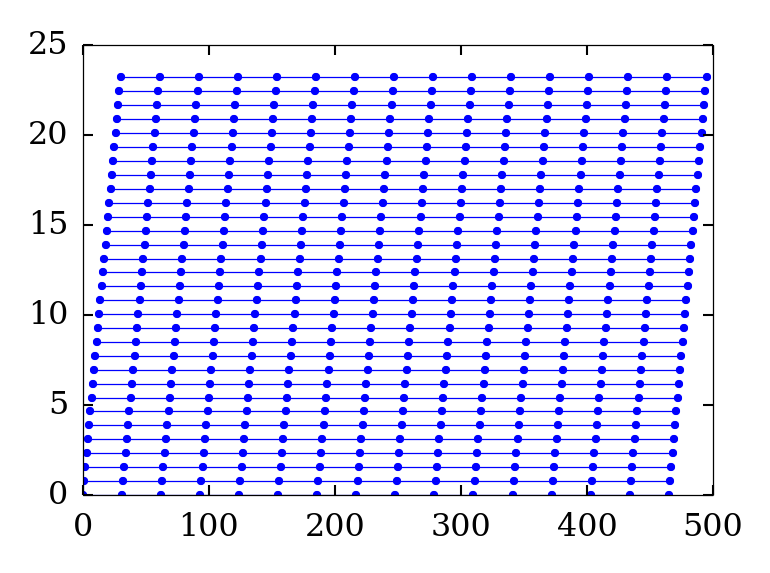

In [37]:
plt.plot(tg.epoch - tg.epoch.min(), '.')
for n in range(frequencies_per_index):
    plt.plot(np.arange(0, n_channels * frequencies_per_index, frequencies_per_index) + n,
             tg.epoch[n::frequencies_per_index] - tg.epoch.min(), '-b')

In [38]:
tg.data_len_seconds[0]

0.52428799999999998

In [39]:
np.all(tg.data_len_seconds == tg.data_len_seconds[0])

True

In [40]:
tg.data[::frequencies_per_index].shape

(16, 8192)

In [41]:
index = sg.index[::frequencies_per_index]